In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from scipy.interpolate import interp1d
from scipy.optimize import minimize

In [69]:
h_data = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Ci_data = [0, 100, 225, 1034, 4750, 11023, 16971, 21692, 26509, 31408, 36377, 41409, 46498]

Ci_func = interp1d(h_data, Ci_data)

In [70]:
S_data = [-100, -0.1, 0, 0.5, 1, 1.5, 2, 100]
Cs_data = [0, 0, 0, 150, 1500, 2000, 2000, 2000]
Cg_data = [0, 0, 0.1, 0.5, 1, 1, 1, 1]

Cs_func = interp1d(S_data, Cs_data)
Cg_func = interp1d(S_data, Cg_data)

Generate the laws for determining that of $C_d$

In [71]:
# Constants
L = 5000    # Length of section (m)
B = 300     # Watercourse width (m)
Zb = 55.5  # Shoreline elevation (m NGF)

# Simulation parameters 
vec_size = 100000                # Points to generate

mode_Q, scale_Q = 1013, 558 # Q law (Gumbel)
exp_K, std_K = 30, 7.5      # Ks law (Gaussian)
exp_Zv, hr_Zv = 50, 1       # Zv law (Triangular)
exp_Zm, hr_Zm = 55, 1       # Zm law (Triangular)

# Generate random variables vectors of size vec_size
Q_vec = stat.gumbel_r.rvs(loc=mode_Q, scale=scale_Q, size=vec_size)
Ks_vec = stat.norm.rvs(loc=exp_K, scale=std_K, size=vec_size)
Zv_vec = stat.triang.rvs(c=1/2, loc=exp_Zv-hr_Zv, scale=2*hr_Zv, size=vec_size)
Zm_vec = stat.triang.rvs(c=1/2, loc=exp_Zm-hr_Zm, scale=2*hr_Zm, size=vec_size)

to_remove_ind = [] # List of indexes that violate positivity criteria
for i in range(len(Q_vec)):
    if Q_vec[i]<=0:
        to_remove_ind.append(i)
    if Ks_vec[i]<=1:
        to_remove_ind.append(i)
to_remove_ind = np.array(to_remove_ind)

# Removing these indices from the dataset
Q_vec = np.delete(Q_vec, to_remove_ind)
Ks_vec = np.delete(Ks_vec, to_remove_ind)
Zv_vec = np.delete(Zv_vec, to_remove_ind)
Zm_vec = np.delete(Zm_vec, to_remove_ind)

H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)
S = Zv_vec + H_vec - Zb

In [72]:
def total_cost(h, T, S):
    """
    h (float): Height of the dike in m
    T (int): Time interval for cost calculation in years
    S (array): Observations of the law of S s.t h=0
    Returns the expected total mean cost for the dike (in M€)
    """
    # Investment and maintenance cost
    Ci = Ci_func(h)/1000 # Conversion to M€
    Ct = (1+T/100)*Ci

    # Cost of damage distribution
    S_truth = S - h
    Cs = Cs_func(S_truth)
    Cg = Cg_func(S_truth)
    Cd = Cs + Cg*Ci

    # Expected mean cost
    Cc_m = Ct/T + np.mean(Cd)
    return Cc_m

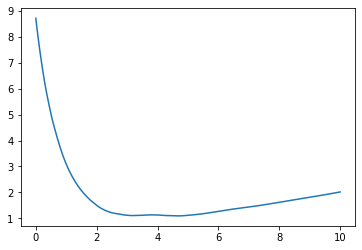

[3.15253796]


In [73]:
h_d = np.linspace(0, 10, 1000) #Test with 100 dike heights between 0 and 5 meters
T = 30 # Time for the cost calculation, here 30 years

Cc_mean = np.array([total_cost(h, T, S) for h in h_d])

plt.figure()
plt.plot(h_d, Cc_mean)
plt.show()

def cost_h(h):
    return total_cost(h, T, S)
res = minimize(cost_h, 1)
print(res['x'])